凸函数：
弦在弧上就是凸函数；

# <a id=1></a> 1 实现 K-Means 算法
K-Means 算法的基本运行流程为：

+ 1 随机选择 $k$ 个点作为初始中心

+ 2 Repeat：

 + 2.1 将每个样本指派到最近的中心，形成 $k$ 个类

 + 2.2 重新计算每个类的中心为该类样本均值

+ 3 直到中心不发生变化

在整个算法中，2.1 步骤运算量最大，因为该步骤需要计算每一个样本到 $k$ 个中心的距离。假设我们的数据集表示为 Pandas 的 DataFrame 格式 `X`。要实现每个样本到中心的距离计算，可以有多种实现方式。最简单的是通过 for 循环遍历 `X` 的每一行，计算每一行到中心的距离。为了提高运算效率，我们可以借助 DataFrame 的 `apply` 函数加快运算。Numpy 是 Python 中矩矩阵运算的高效工具，我们也可以使用矩阵运算的方式来实现样本到中心的距离计算。下面，我们分别来看下这三种实现方法。

## <a id=1.1></a>1.1 使用 `iterrows` 遍历的方式实现

假设我们使用欧式距离计算样本到中心的距离。对于样本 $d$ 维样本 $\mathbf{x}$ 到中心 $\mathbf{c}$ 的欧式距离计算公式为：

$$
\text{dist}(\mathbf{x},\mathbf{c}) = \sqrt{\sum_{i=1}^{d} (x_i-c_i)^2} = \Vert \mathbf{x} - \mathbf{c}\Vert_2.
$$

使用最简单的方式来实现，先用一个函数 `point_dist` 计算一个样本到中心的距离。这里我们使用 Numpy 的线性代数模块 `linalg` 中的 `norm` 方法。

In [1]:
import numpy as np
def point_dist(x,c): #定义距离计算函数
    return np.linalg.norm(x-c)

然后使用 `iterrows` 方法遍历样本计算样本到中心的距离，定义 `k_means_iterrows` 方法实现 K-Means 算法。

In [2]:
def k_means1(X,k):
    centers = X.sample(k).values #从数据集随机选择 K 个样本作为初始化的类中心，k 行 d 列
    X_labels = np.zeros(len(X)) #样本的类别
    error = 10e10
    while(error > 1e-6):
        for i,x in X.iterrows():#指派样本类标签
            X_labels[i] = np.argmin([point_dist(x,centers[i,:]) for i in range(k)])
        centers_pre = centers
        centers = X.groupby(X_labels).mean().values #更新样本均值，即类中心
        error = np.linalg.norm(centers_pre - centers)#计算error
    return X_labels, centers

用一个简单的随机数据集来测试时间性能。Sklearn 中的 `datasets` 模块的 `make_blobs` 函数能够自动生成一些供测试聚类算法的随机数据集。它能够根据输入的参数生成数据集和对应的类标签。常用的参数如下表：

|参数|含义说明|
|:----|:---|
|n_samples|需要生成的样本数量,默认值100 |
|n_features | 特征数量，默认值是2 |
|centers | 数据的中心点数量，默认值3 |
|cluster_std | 数据集的标准差，浮点数或者浮点数序列，默认值1.0 |
|center_box | 中心确定之后的数据边界，默认值(-10.0, 10.0) |
|shuffle | 打乱样本顺序，默认值是True |
|random_state |官网解释是随机生成器的种子 |

In [3]:
from sklearn import datasets
import pandas as pd
X, y = datasets.make_blobs(n_samples=5000, n_features=8, cluster_std = 0.5,centers=3,random_state=99)
X_df = pd.DataFrame(X)

在该数据集上用我们实现的 `k_means1` 方法运行 K-Means 聚类。使用 `iPython` 提供的魔法命令 `%time` 记录运行时间。

In [4]:
%time labels,centers = k_means1(X_df,3) # for 循环

CPU times: user 6.5 s, sys: 86.3 ms, total: 6.59 s
Wall time: 7.75 s


## <a id=1.2 ></a>  1.2 使用 `apply` 遍历的方式实现

提高运算效率，可以使用 `DataFrame` 的 `apply` 函数，它可以对数据框中的每一行执行一个复杂的函数。在我们的例子中，是计算每一行与每一个中心的距离。

In [5]:
def k_means2(X,k):
    #初始化 K 个中心，从原始数据中选择样本
    centers = X.sample(k).values
    X_labels = np.zeros(len(X)) #样本的类别
    error = 10e10
    while(error > 1e-6):
        #********#
        X_labels = X.apply(lambda r : np.argmin([point_dist(r,centers[i,:]) for i in range(k)]),axis=1)
        centers_pre = centers
        centers = X.groupby(X_labels).mean().values #更新样本均值，即类中心
        error = np.linalg.norm(centers_pre - centers)#计算error
    return X_labels, centers

In [6]:
%time labels,centers = k_means2(X_df,3) # apply 运算

CPU times: user 1min 4s, sys: 691 ms, total: 1min 5s
Wall time: 1min 5s


## <a id=1.3 ></a> 1.3 矩阵运算的方式实现

数据集表示成 $n \times d$ 矩阵 $\mathbf{X}$，其中 $n$ 为样本数量，$d$ 为样本的维度。 $k$ 个聚类中心表示成 $k \times d$ 矩阵 $\mathbf{C}$，$\mathbf{C}$ 每一行表示一个聚类中心。样本到 $k$ 个中心的距离表示成 $n \times k$ 矩阵 $\mathbf{D}$。

已经聚类中心，计算样本到中心距离，并将样本划分到距离最小的类的流程如下图所示。

![png](http://cookdata.cn/media/note_images/样本列表计算流程_1591523655137_5d14.jpg)

使用 Numpy 实现上述计算流程的代码为：

```python
for i in range(k):

    D[:,i] = np.sqrt(np.sum(np.square(X - C[i,:]),axis=1))
    
labels = np.argmin(D,axis=1)
```
得到样本的类标签后，聚类中心的更新流程为：1）根据类标签对样本进行分组；2）将聚类中心更新为每一组样本的均值。Python 实现的代码为：

```python
 C = X.groupby(labels).mean().values
```

现在我们更新 K-Means 算法的实现，函数名为 `k_means`。

In [7]:
import pandas as pd
import numpy as np
def k_means(X,k):
    C = X.sample(k).values  #从数据集随机选择 K 个样本作为初始化的类中心，k 行 d 列
    X_labels = np.zeros(len(X)) #记录样本的类别
    error = 10e10 #停止迭代的阈值
    while(error > 1e-6):
        D = np.zeros((len(X),k)) #样本到每一个中心的距离，n 行 k 列
        for i in range(k):
            D[:,i] = np.sqrt(np.sum(np.square(X - C[i,:]),axis=1))
        labels = np.argmin(D,axis=1)
        C_pre = C
        
        temp_C = X.groupby(labels).mean() #更新样本均值，即类中心
        C = np.zeros((k,X.shape[1]))
        for i in temp_C.index:
            C[i,:] = temp_C.loc[i,:].values
            
        if C.shape == C_pre.shape:
            error = np.linalg.norm(C_pre - C)#计算error
        else:
            print(C.shape, C_pre.shape)
    return labels, C

In [8]:
%time labels,centers = k_means(X_df,3) # 矩阵运算

CPU times: user 28.3 ms, sys: 1.47 ms, total: 29.8 ms
Wall time: 28.8 ms


## <a id=1.4 ></a> 1.4 聚类结果可视化

下面我们使用一份随机生成的二维数据集，使用我们上一小节实现的 `k_means` 完成聚类，然后使用不同颜色标注不同类的样本以及类中心。

In [9]:
color_dict = {0:"#E4007F",1:"#007979",2:"blue",3:"orange"} #洋红，深绿，蓝色，橘色

Text(0, 0.5, '$x_2$')

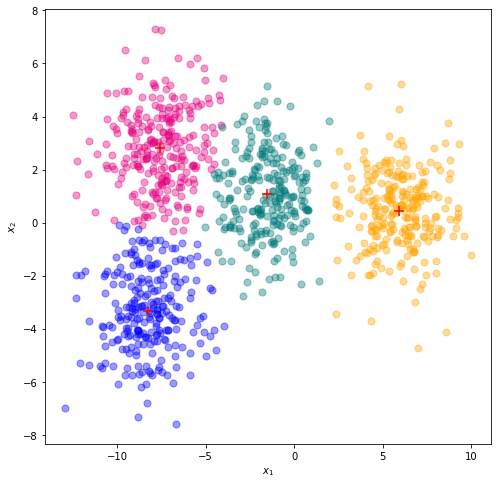

In [10]:
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
X, y = datasets.make_blobs(n_samples=1000, n_features=2, cluster_std = 1.5,centers=4,random_state=999)
X_df = pd.DataFrame(X,columns=["x1","x2"])
labels,centers= k_means(X_df,4)
fig, ax = plt.subplots(figsize=(8, 8)) #设置图片大小
for i in range(len(centers)):
    ax.scatter(X_df[labels == i]["x1"],X_df[labels == i]["x2"],color=color_dict[i],s=50,alpha=0.4)
    ax.scatter(centers[int(i),0],centers[int(i),1],color="r",s=100,marker="+")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

## <a id=1.5 ></a>  1.5 使用动画展示 K-Means 聚类过程

要动态展示 K-Means 聚类过程，我们需要在每一步迭代中记录每一个类的中心，以及每一个类的样本集合。创建 `k_means_steps`，在完成聚类的同时，将每一步迭代的每类样本和中心返回。

In [11]:
def k_means_steps(X,k):
    #初始化 K 个中心，从原始数据中选择样本
    #********#
    samples_list = [] #记录每一个中间迭代中每一类样本
    centers_list = [] #记录每一个中间迭代中每一类样本中心
    #********#
    C = X.sample(k).values
    labels = np.zeros(len(X)) #样本的类别
    error = 10e10
    while(error > 1e-6):
        D = np.zeros((len(X),k)) #样本到每一个中心的距离
        for i in range(k):
            D[:,i] = np.sqrt(np.sum(np.square(X - C[i,:]),axis=1))
        labels = np.argmin(D,axis=1)
        C_pre = C
        C = X.groupby(labels).mean().values #更新样本均值，即类中心
        #********# 记录当前迭代地每一类的样本集合和中心
        samples,centers2 = [],[]
        for i in range(k): 
            samples.append(X[labels == i])
            centers2.append(C[i,:])
            
        samples_list.append(samples)
        centers_list.append(centers2)
        #********#
        if C.shape == C_pre.shape:
            error = np.linalg.norm(C_pre - C)#计算error
        else:
            print(C.shape, C_pre.shape)
    return labels, C,samples_list,centers_list #********# 返回最终的聚类结果，聚类中心，每一步的聚类结果和聚类中心

我们可以借助 `matplotlib.animation` 动画模块来实现下面的 `init_draw` 函数是动画最开始时绘制的内容，包含数据。`update_draw` 则是每次更新的内容。

In [12]:
labels,centers,samples_list,centers_list= k_means_steps(X_df,4)
fig, ax = plt.subplots(figsize=(8, 8))

samples_obj = []
centers_obj = []

def init_draw(): # 展现样本数据
    ax.set_title("Process of K-Means:")
    for i in range(len(centers)):
        samples_obj.append(ax.scatter(samples_list[0][i]["x1"],samples_list[0][i]["x2"],color=color_dict[i],s=50,alpha=0.6))
        centers_obj.append(ax.scatter(centers_list[0][i][0],centers_list[0][i][1],color="r",s=100,marker="+"))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
        
def update_draw(t): # 实现动画中每一帧的绘制函数，i为第几帧
    ax.set_title("Process of K-Means:" + str(t))
    samples,centers = samples_list[t],centers_list[t]
    for i in range(len(centers)):
        samples_obj[i].set_offsets(samples[i])
        centers_obj[i].set_offsets(centers[i])
    plt.close()
    
#演示决策面动态变化
import matplotlib.animation as animation
from IPython.display import HTML
animator = animation.FuncAnimation(fig, update_draw, frames= range(1,len(centers_list)), init_func=init_draw,interval=2000)
HTML(animator.to_jshtml())

## <a id=1.6 ></a>  1.6 失真度量 J 的变化
我们来查看随着迭代的进行，K-Means聚类模型的优化目标，即失真度量 $J$ 的变化。对算法进行修改，记录每一步的失真度量。

In [13]:
import pandas as pd
import numpy as np
def k_means_inertia(X,k):
    #初始化 K 个中心，从原始数据中选择样本
    C = X.sample(k).values
    labels = np.zeros(len(X)) #样本的类别
    inertia_list = [] #*****记录优化目标****#
    error = 10e10
    while(error > 1e-6):
        D = np.zeros((len(X),k)) #样本到每一个中心的距离
        for i in range(k):
            D[:,i] = np.sqrt(np.sum(np.square(X - C[i,:]),axis=1))
        labels = np.argmin(D,axis=1)
        
        inertia_list.append(np.square(np.min(D,axis=1)).sum()) #****记录当前步骤的失真度量****#
        
        C_pre = C
        temp_C = X.groupby(labels).mean() #更新样本均值，即类中心
        C = np.zeros((k,X.shape[1]))
        for i in range(len(temp_C)):
            C[i,:] = temp_C.loc[i,:].values
        if C.shape == C_pre.shape:
            error = np.linalg.norm(C_pre - C)#计算error
    return labels,C,inertia_list

在随机数据上进行聚类，并将失真度量的变化以折线图的形式绘制出来。

Text(0.5, 1.0, 'K-Means')

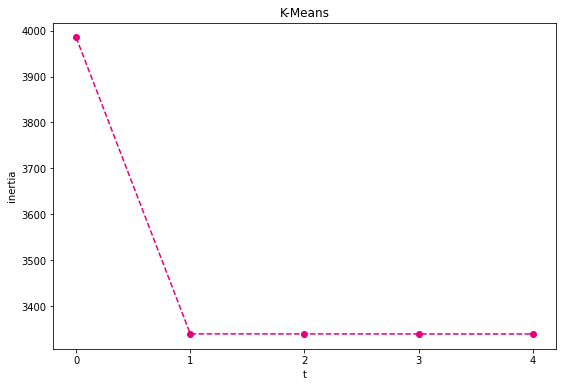

In [17]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, cluster_std=1,centers=3,random_state=99)
X_df = pd.DataFrame(X,columns=["x1","x2"])
labels,centers,inertia_list = k_means_inertia(X_df,3)
fig, ax = plt.subplots(figsize=(9, 6)) #设置图片大小
t = range(len(inertia_list))
plt.plot(t,inertia_list,c="#E4007F",marker="o",linestyle='dashed')
plt.xlabel("t")
plt.ylabel("inertia")
plt.xticks(t)
plt.title("K-Means")

# <a id=2 ></a> 2 使用 K-Means 算法进行图像分割

我们先加载一张测试图片，将图片打印出来。使用 `PIL.Image.open` 方法来打开图片，然后使用 `matplotlib` 中的 `imshow` 方法将图片可视化。 

(-0.5, 599.5, 514.5, -0.5)

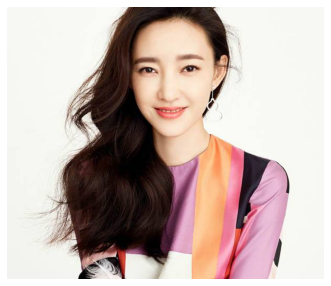

In [20]:
from PIL import Image
fig, ax = plt.subplots(figsize=(6, 5)) #设置图片大小
path = './timg.jpg'
img = Image.open(path)
plt.imshow(img)
plt.box(False) #去掉边框
plt.axis("off")#不显示坐标轴

将一张图片转换成表格形式。每一行为一个像素，三列分别为像素的 R，B，G取值。获取图片的每一个像素 $(i,j)$ 的 RBG 值可以使用 `Image` 类的 `getpixel` 方法。

In [22]:
import pandas as pd
def image_dataframe(image): #将图片转换成DataFrame,每个像素对应每一行，每一行包括三列
    rbg_values = []
    for i in range(image.size[0]):
        for j in range(image.size[1]):
            x,y,z= image.getpixel((i,j)) # 获取图片的每一个像素  (i,j)(i,j)  的 RBG 值
            rbg_values.append([x,y,z])
    return pd.DataFrame(rbg_values,columns=["R","B","G"]),img.size[0],img.size[1]

img_df,m,n = image_dataframe(img)

打印转换的数据框如下：

In [24]:
img_df.head()

,R,B,G
0,247,248,243
1,247,248,243
2,247,248,243
3,247,248,243
4,247,248,243


使用我们在上一节实现的 K-Means 算法对像素进行聚类。

In [26]:
labels, _ = k_means(img_df,2)

将生成的灰度图可视化，对图像可视化使用 `plt.imshow` 方法。

(-0.5, 599.5, 514.5, -0.5)

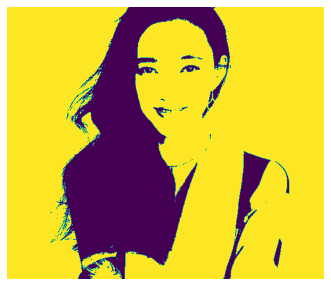

In [28]:
fig, ax = plt.subplots(figsize=(6, 5)) #设置图片大小
labels = labels.reshape((m,n))
pic_new = Image.new("L",(m,n))
#根据类别向图片中添加灰度值
for i in range(m):
    for j in range(n):
        pic_new.putpixel((i,j),int(256/(labels[i][j] + 1)))
plt.imshow(pic_new)
plt.box(False) #去掉边框
plt.axis("off")#不显示坐标轴  

实现一个函数 `img_from_labels` ，将像素聚类类别标签，转换成一张灰度图。

In [31]:
def img_from_labels(labels,m,n):
    labels = labels.reshape((m,n))
    pic_new = Image.new("L",(m,n))
    #根据类别向图片中添加灰度值
    for i in range(m):
        for j in range(n):
            pic_new.putpixel((i,j),int(256/(labels[i][j] + 1)))
    return pic_new

调整聚类数量 $k$, 将聚类得到的不同的灰度图使用 `Matplotlib` 将生成的灰度图绘制出来。

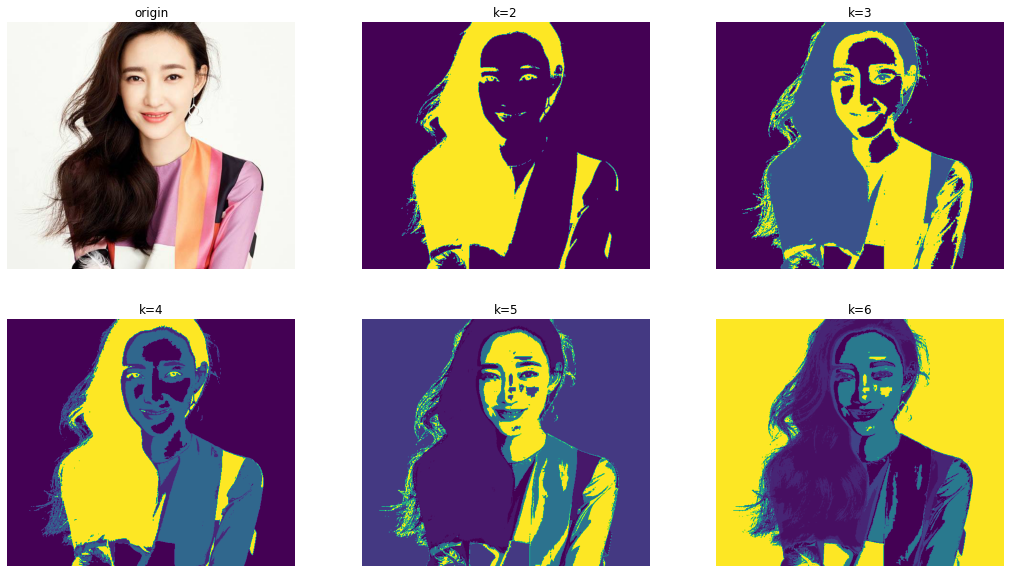

In [34]:
fig, ax = plt.subplots(figsize=(18, 10)) #设置图片大小
img = Image.open(path) #显示原图
plt.subplot(2,3,1)
plt.title("origin")
plt.imshow(img)
plt.box(False) #去掉边框
plt.axis("off")#不显示坐标轴

for i in range(2,7):
    plt.subplot(2,3,i)
    plt.title("k=" + str(i))
    labels, _ = k_means(img_df,i)
    pic_new = img_from_labels(labels,m,n)
    plt.imshow(pic_new)
    plt.box(False) #去掉边框
    plt.axis("off")#不显示坐标轴  